<a href="https://colab.research.google.com/github/DommiiUdomp/Well/blob/main/tryDEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas contextily geoplot tqdm osmnx

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
import geoplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, box

%matplotlib inline

import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import box
from rasterio.plot import show_hist

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.1.2'

# ***EE MAP***

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=O-0NOjXsx_TFp_H-ZpaxwUV740NCwEBxfjGopqlm5Iw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiRcm4A96z3UvJs3cF8AAwSkWd1VCJXMmi57GXs7alpaJ0iULEtdC8

Successfully saved authorization token.


In [3]:
#test API # Print the elevation of Mount Everest.
elv = ee.Image('USGS/SRTMGL1_003')
pxy = ee.Geometry.Point([86.9250, 27.9881])
p = elv.sample(pxy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', p)

Mount Everest elevation (m): 8729


In [4]:
slope = ee.Terrain.slope(elv)
topo = ee.Image.cat(elv, slope)
topoCol = ee.ImageCollection([topo])

# ***Place***

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


<AxesSubplot:title={'center':'Tiszaújváros, Tiszaújvárosi járás, Borsod-Abaúj-Zemplén megye, Észak-Magyarország, Alföld és Észak, Magyarország'}, xlabel='X', ylabel='Y'>

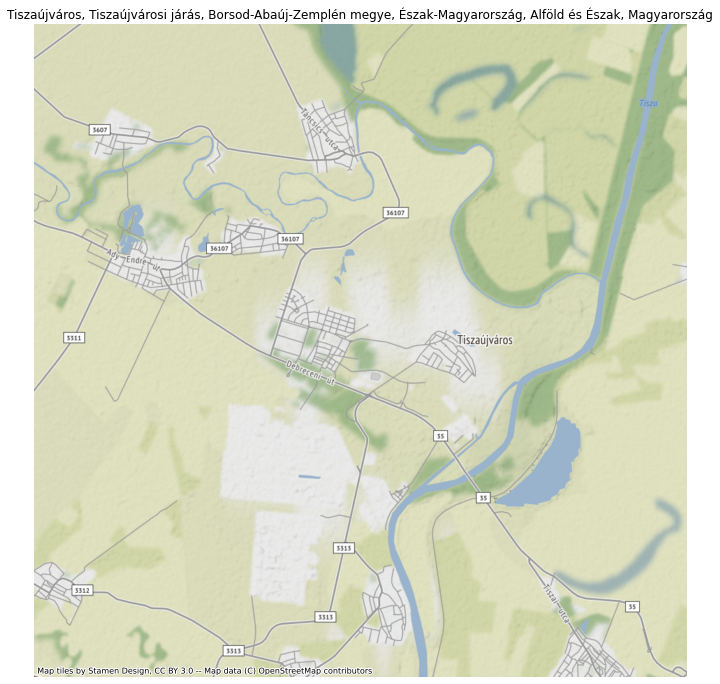

In [5]:
%time 
tisza_hu = cx.Place("Tiszaújváros, HU")
tisza_hu.plot()

In [6]:
# Create random points within map bbox
Y = np.random.uniform(low=tisza_hu.bbox_map[2], high=tisza_hu.bbox_map[3], size=(5000,))
X = np.random.uniform(low=tisza_hu.bbox_map[1], high=tisza_hu.bbox_map[0], size=(5000,))
r_points = [Point(x,y) for x,y in zip(X,Y)]
df = gpd.GeoDataFrame(r_points, geometry=0, crs='epsg:3857')

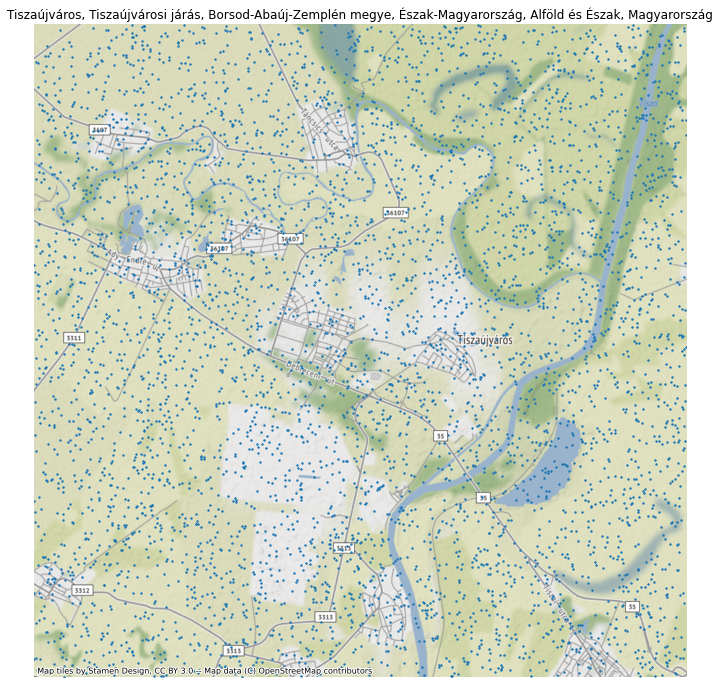

In [7]:
ax = tisza_hu.plot()
ax2 = df.plot(ax=ax, markersize=2)

In [8]:
# Create random points within map bbox
Y = np.random.uniform(low=tisza_hu.s, high=tisza_hu.n, size=(5000,))
X = np.random.uniform(low=tisza_hu.e, high=tisza_hu.w, size=(5000,))
ppoints = [ee.Geometry.Point(x,y) for x,y in zip(X,Y)]

In [ ]:
# make features from points (name by list order)
feats = [ee.Feature(p, {'name': 'node{}'.format(i)}) for i, p in enumerate(ppoints)]

# make a featurecollection from points
fc = ee.FeatureCollection(feats)

# extract points from DEM
reducer = ee.Reducer.first()
data = elv.reduceRegions(fc, reducer.setOutputs(['elevation']), 30)

# see data
for feat in data.getInfo()['features']:
    print(feat['properties'])

# export as CSV
task = ee.batch.Export.table.toDrive(data, 'pointsDataExtract', 'FOLDER', 'nameOfCSV')
task.start()

# ***Import File***

In [81]:
df_elv = pd.read_csv('/content/nameOfCSV.csv')
df_elv.head()

,system:index,elevation,name,.geo
0,0,94,node0,"{""type"":""Point"",""coordinates"":[21.010618549998..."
1,1,87,node1,"{""type"":""Point"",""coordinates"":[21.081539454463..."
2,2,92,node2,"{""type"":""Point"",""coordinates"":[21.071980747077..."
3,3,91,node3,"{""type"":""Point"",""coordinates"":[21.112477517146..."
4,4,95,node4,"{""type"":""Point"",""coordinates"":[21.038970703738..."


In [82]:
df_elv[['p','coor']] = df_elv['.geo'].str.split('[',expand = True)

In [83]:
df_elv['coor'] = df_elv['coor'].str[:35]
df_elv[['lon','lat']] = df_elv['coor'].str.split(',',expand = True)

In [84]:
df_elv['lon'] = df_elv['lon'].str[:9].astype(float).round(5)
df_elv['lat'] = df_elv['lat'].str[:9].astype(float).round(5)
df_elv['elevation'] = df_elv['elevation'].astype(int)
df_elv.drop(columns=['system:index','name','p','coor','.geo'], inplace=True)
df_elv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   elevation  5000 non-null   int64  
 1   lon        5000 non-null   float64
 2   lat        5000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 117.3 KB


In [ ]:
#df_elv['.geo'].astype('str').str.extractall('(\d+)').unstack()#.fillna('').sum(axis=1).astype(int)

# ***Reshape DEM Data***

In [40]:
lon = pd.Series(df_elv['lon'].loc[:4899]) 
lon = lon.values.reshape((70, 70))
lat = pd.Series(df_elv['lat'].loc[:4899]) 
lat = lat.values.reshape((70, 70))
elevation = pd.Series(df_elv['elevation'].loc[:4899]) 
elevation = elevation.values.reshape((70, 70))

In [62]:
aa.shape

(5000, 1)

In [29]:
lon.shape

(70, 70)

In [30]:
np.savez_compressed('/content/tiszaDEM', lon=lon, lat=lat,elevation=elevation)

In [31]:
tiszaDEM = np.load('/content/tiszaDEM.npz')

In [32]:
type(tiszaDEM)

numpy.lib.npyio.NpzFile

In [33]:
lst = tiszaDEM.files
for item in lst:
    print(item)
    print(tiszaDEM[item])

lon
[[21.01062 21.08154 21.07198 ... 21.09376 21.09136 21.06245]
 [21.08823 21.0468  21.0243  ... 21.0241  21.03831 21.00647]
 [21.064   21.08952 21.10394 ... 21.04144 21.1125  21.08002]
 ...
 [21.01748 21.05022 21.09894 ... 21.00112 21.08099 21.06892]
 [21.09564 21.01751 21.05713 ... 21.05285 21.00598 21.05103]
 [21.01692 21.02316 21.0603  ... 21.11053 21.01684 21.08517]]
lat
[[47.91836 47.89106 47.90912 ... 47.94187 47.88666 47.88726]
 [47.96058 47.95355 47.94629 ... 47.89465 47.92684 47.92965]
 [47.89345 47.89715 47.96749 ... 47.94228 47.8782  47.9663 ]
 ...
 [47.90093 47.92739 47.96701 ... 47.89108 47.964   47.91325]
 [47.90004 47.92014 47.96999 ... 47.87907 47.87626 47.96617]
 [47.95461 47.96451 47.88412 ... 47.90586 47.88164 47.87746]]
elevation
[[94 87 92 ... 99 91 91]
 [89 92 92 ... 93 95 95]
 [88 88 91 ... 92 92 90]
 ...
 [92 90 91 ... 92 89 95]
 [88 87 89 ... 90 94 92]
 [92 95 93 ... 90 91 88]]


In [34]:
tiszaDEM['elevation'].shape

(70, 70)

# ***Plot Elevation***

In [7]:
from matplotlib.colors import LightSource

In [46]:
# Load and format data
from matplotlib.cbook import get_sample_data
dem = get_sample_data('jacksboro_fault_dem.npz', np_load=True)
z = dem['elevation']
nrows, ncols = z.shape
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)
x, y = np.meshgrid(x,y)

region = np.s_[5:50, 5:50]
xx, yy, zz = x[region], y[region], z[region]*2

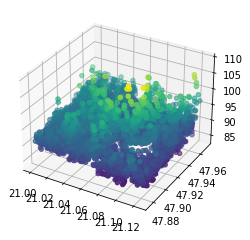

In [8]:
ax = plt.axes(projection='3d')
ax.scatter(df_elv['lon'], df_elv['lat'], df_elv['elevation'], c =df_elv['elevation'])

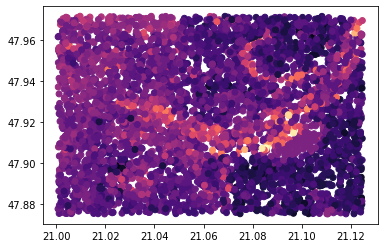

In [56]:
xx = np.ravel(df_elv['lon'])
yy = np.ravel(df_elv['lat']) 
zz = np.ravel(df_elv['elevation'])

plt.scatter(xx,yy,c=zz,cmap=plt.cm.magma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'interpolation'
  after removing the cwd from sys.path.


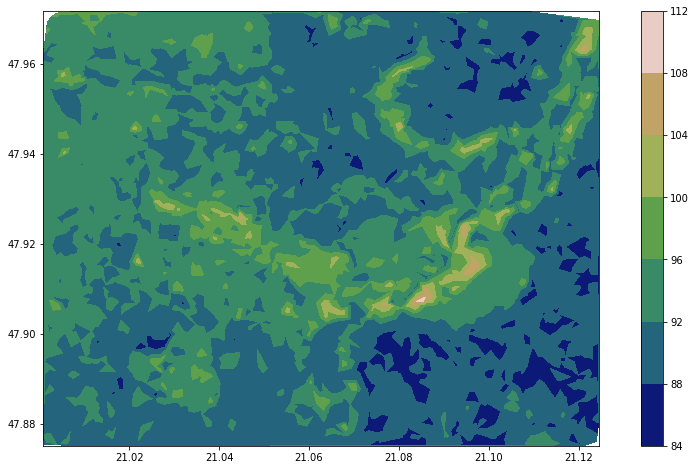

In [60]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_aspect('equal')

cf = ax.tricontourf(df_elv['lon'], df_elv['lat'], df_elv['elevation'], cmap=plt.cm.gist_earth, interpolation='gaussian')
fig.colorbar(cf, ax=ax)

plt.show()

In [15]:
x= np.array(df_elv['lon'][:1000])
y= np.array(df_elv['lat'][:1000]) 
z= np.array(df_elv['elevation'][:1000])
xx, yy = np.meshgrid(x, y)

In [ ]:
#zz, zz= np.meshgrid(z, z)
#z_grid = np.c_[ np.ravel(zz)]#np.c_[ np.ravel(zz), np.ravel(zz) ]
#z_grid.shape

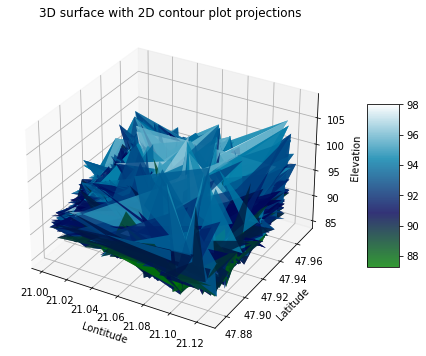

In [51]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(lon,lat,elevation, rstride=1, cstride=1, alpha=0.8, cmap=plt.cm.ocean, edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('Lontitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')
ax.set_zlim(np.min(elevation), np.max(elevation))
ax.set_title('3D surface with 2D contour plot projections')


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


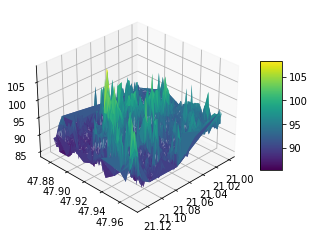

In [87]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df_elv['lon'], df_elv['lat'], df_elv['elevation'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, 45)
plt.show()

In [88]:
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [91]:
df_elv['lon'].max()

21.12461

In [92]:
len(Z)/3

1666.6666666666667

In [101]:
X = df_elv['lon'] 
Y = df_elv['lat']
Z = df_elv['elevation']
xi = np.linspace(X.min(),X.max(),(1500))
yi = np.linspace(Y.min(),Y.max(),(1500))
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='nearest')

xig, yig = np.meshgrid(xi, yi)

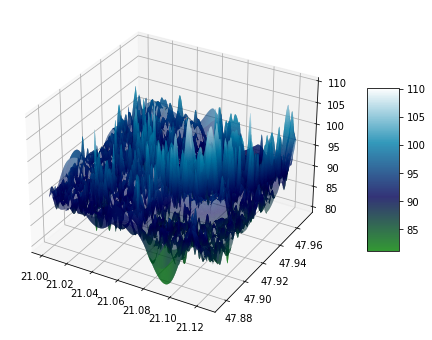

In [100]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(xig,yig,zi, rstride=1, cstride=1, alpha=0.8, cmap=plt.cm.ocean, edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

# ***SHP file***

In [ ]:
!wget 'https://biogeo.ucdavis.edu/data/diva/adm/HUN_adm.zip'

In [ ]:
!unzip '/content/HUN_adm.zip'

In [ ]:
HUN_adm0 = gpd.read_file('/content/HUN_adm0.shp')
HUN_adm1 = gpd.read_file('/content/HUN_adm1.shp')
HUN_adm2 = gpd.read_file('/content/HUN_adm2.shp')

HUN_adm2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

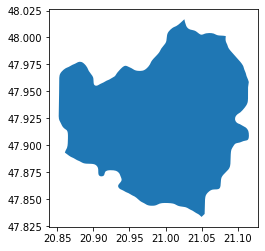

In [ ]:
Tiszaújváros = HUN_adm2[HUN_adm2['NAME_2'] =='Tiszaújváros']
Tiszaújváros.drop(columns=['ID_0',	'ISO', 'ID_1', 'ID_2','NL_NAME_2'],inplace=True)
Tiszaújváros.plot()

In [ ]:
Tiszaújváros

,NAME_0,NAME_1,NAME_2,TYPE_2,ENGTYPE_2,VARNAME_2,geometry
40,Hungary,Borsod-Abaúj-Zemplén,Tiszaújváros,Kistérség,Subregion,None,"POLYGON ((21.11533 47.95866, 21.11432 47.95377..."


In [ ]:
Tiszaújváros.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

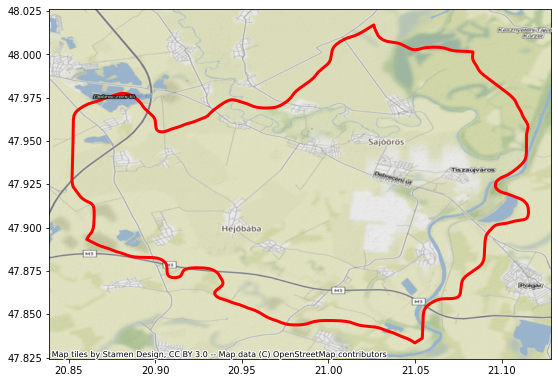

In [ ]:
ax = Tiszaújváros.plot(figsize=(9,9), color="none", edgecolor="r", linewidth=3)
cx.add_basemap(ax, crs=Tiszaújváros.crs.to_string(), source=cx.providers.Stamen.Terrain)
cx.add_basemap(ax, crs=Tiszaújváros.crs.to_string(), source=cx.providers.Stamen.TonerLabels)